# Business case: Understanding profitability in the US financial market

This is business case prepared for the Statistics Module (Bloque 1) of the Advanced AI concentration

## Case Description

You were hired as a data scientist in an important mutual fund firm in the department of financial analysis. The firm has been doing financial analysis and financial forecast for several years. You were hired to come up with alternative approaches to do descriptive analytics in order to find better future alternatives for forecasting methods.

You have to analyze historical quarterly financial statements of all US public firms listed in the New York Exchange and NASDAQ. You will receive this dataset in a .csv format.

You have to carefully read the data dictionary to understand each variable and the dataset to understand its structure.

## Business Questions

All your data and statistical analysis has to be tailored to respond the following questions:

### General questions:

By industry, what is the composition of US public firms in terms of firm size, sales performance and profitability?

Why some firms are more profitable than others? Which factors/variables from financial statements are related to stock returns

### Specific questions:
-----

In [1]:
# Data management module
import numpy as np
import pandas as pd
# Visualization modules
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# Linear regression modules
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
# Statistic module
import statsmodels.api as sm
import statsmodels.formula.api as smf
# quit warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Open de .csv files

In [3]:
# https://apradie.com/datos/us2022q2a.csv
us = pd.read_csv('us2022q2a.csv')

# https://apradie.com/datos/usfirms2022.csv
firms = pd.read_csv('usfirms2022.csv')

In [4]:
us.columns

Index(['firm', 'q', 'revenue', 'cogs', 'sgae', 'otheropexp', 'extraincome',
       'finexp', 'incometax', 'totalassets', 'totalliabilities', 'shortdebt',
       'longdebt', 'stockholderequity', 'adjprice', 'originalprice',
       'sharesoutstanding', 'fiscalmonth', 'year', 'cto'],
      dtype='object')

In [5]:
firms.columns

Index(['Ticker', 'Name', 'N', 'Class', 'Country\nof Origin', 'Type of Asset',
       'Sector NAICS\nlevel 1', 'Exchange / Src', 'Sector\nEconomatica',
       'Sector NAICS\nlast available', 'partind'],
      dtype='object')

#### Merge both tables

In [6]:
us_firms = us.merge(firms, left_on='firm', right_on='Ticker')
us_firms.head()

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Name,N,Class,Country\nof Origin,Type of Asset,Sector NAICS\nlevel 1,Exchange / Src,Sector\nEconomatica,Sector NAICS\nlast available,partind
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
1,A,2000q2,2485000.0,1261000.0,1010000.0,0.0,42000.0,0.0,90000.0,7321000.0,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
2,A,2000q3,2670000.0,1369000.0,1091000.0,0.0,28000.0,0.0,83000.0,7827000.0,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
3,A,2000q4,3372000.0,1732000.0,1182000.0,0.0,10000.0,0.0,163000.0,8425000.0,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124
4,A,2001q1,2841000.0,1449000.0,1113000.0,0.0,-6000.0,0.0,119000.0,9208000.0,...,"Agilent Technologies, Inc",94,Com,US,Stock,Manufacturing,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124


#### Get variable calculations

Variable calculations:
  - Firm size measures:
    + Book value of the firm = (totalassets-totalliabilities)
    + Market value = (precio del stock histórico)
    + Market value = (originalprice * sharesoutstanding)
    <br><br>
  - Profit Margin measures:
    + Operating profit margin = operating profit / sales
      * Operating profit = ebit = (revenue - cogs - sgae - otheropexp)
      * Cogs = Cost of Good Sold = Variable cost
      * Sgae = Sales and General Administrative Expenses = Fixed costs
      * Ebit = Earning before Interst and Taxes = Operating profit

	ebit = revenue - cogs - sgae - otheropexp<br>
	operating profit margin = opm = ebit / revenue<br>
  revenue = sales<br>

    Profit margin = Net income / sales<br>
    Net income = ebit - incometax - finexp<br>
    Income tax = what the firm pays in taxes (for the government)(impuesto sobre la renta)<br>
    Finexp = financial expenses = what the firm pays in interest expenses for any loan that the firm issued<br>

In [7]:
# Firm size measures
us_firms['Book value of the firms'] = us_firms['totalassets'] - us_firms['totalliabilities']
us_firms['Market value'] = us_firms['originalprice'] * us_firms['sharesoutstanding']

# Profit Margin measures
us_firms['Operating profit'] = us_firms['revenue'] - us_firms['cogs'] - us_firms['sgae'] - us_firms['otheropexp']
# us_firms['Ebit'] = us_firms['revenue'] - us_firms['cogs'] - us_firms['sgae'] - us_firms['otheropexp']
us_firms['opm'] = us_firms['Operating profit'] / us_firms['revenue']
us_firms['Net income'] = us_firms['Operating profit'] - us_firms['incometax'] - us_firms['finexp']
us_firms['Profit margin'] = us_firms['Net income'] / us_firms['revenue']
us_firms.head()

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Exchange / Src,Sector\nEconomatica,Sector NAICS\nlast available,partind,Book value of the firms,Market value,Operating profit,opm,Net income,Profit margin
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124,NaN,4.700800e+07,NaN,NaN,NaN,NaN
1,A,2000q2,2485000.0,1261000.0,1010000.0,0.0,42000.0,0.0,90000.0,7321000.0,...,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124,4642000.0,3.335506e+07,214000.0,0.086117,124000.0,0.049899
2,A,2000q3,2670000.0,1369000.0,1091000.0,0.0,28000.0,0.0,83000.0,7827000.0,...,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124,4902000.0,2.216940e+07,210000.0,0.078652,127000.0,0.047566
3,A,2000q4,3372000.0,1732000.0,1182000.0,0.0,10000.0,0.0,163000.0,8425000.0,...,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124,5265000.0,2.498606e+07,458000.0,0.135824,295000.0,0.087485
4,A,2001q1,2841000.0,1449000.0,1113000.0,0.0,-6000.0,0.0,119000.0,9208000.0,...,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124,5541000.0,1.403653e+07,279000.0,0.098205,160000.0,0.056318


#### Get actual information

In [8]:
aux = us_firms['q'] == '2022q2'
us_firms2022 = us_firms[aux]
us_firms2022.head()

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Exchange / Src,Sector\nEconomatica,Sector NAICS\nlast available,partind,Book value of the firms,Market value,Operating profit,opm,Net income,Profit margin
89,A,2022q2,1607000.0,746000.0,501000.0,0.0,-7000.0,20000.0,59000.0,10455000.0,...,NYSE,Electric Electron,"Navigational, Measuring, Electromedical, and C...",0.124,5122000.0,3.547756e+07,360000.0,0.224020,281000.0,0.174860
179,AA,2022q2,3644000.0,2767000.0,220000.0,-75000.0,81000.0,30000.0,234000.0,15709000.0,...,NYSE,Basic & Fab Metal,Alumina and Aluminum Production and Processing,-,7292000.0,8.407171e+06,732000.0,0.200878,468000.0,0.128430
269,AAIC,2022q2,10900.0,6374.0,0.0,0.0,-3417.0,0.0,802.0,1084755.0,...,NYSE,Funds,Other Investment Pools and Funds,-,213698.0,1.138033e+05,4526.0,0.415229,3724.0,0.341651
359,AAL,2022q2,13422000.0,0.0,12405000.0,0.0,25000.0,439000.0,127000.0,67963000.0,...,NASDAQ,Transportat Serv,Scheduled Air Transportation,0.032,-8422000.0,8.235848e+06,1017000.0,0.075771,451000.0,0.033602
449,AAME,2022q2,44669.0,0.0,46784.0,0.0,0.0,0.0,-436.0,379274.0,...,NASDAQ,Finance and Insurance,Insurance Carriers,-,109101.0,5.446399e+04,-2115.0,-0.047348,-1679.0,-0.037588


#### __About descriptive statistics:__

##### __Considering the most recent financial quarter of the dataset:__

- __Show how many firms by industry there are in the sample__

In [9]:
firmsbyindustry = firms['Sector NAICS\nlevel 1'].value_counts()
firmsbyindustry

Manufacturing                                                               1567
Finance and Insurance                                                        703
Information                                                                  263
Retail Trade                                                                 152
Professional, Scientific, and Technical Services                             145
Administrative and Support and Waste Management and Remediation Services     133
Mining, Quarrying, and Oil and Gas Extraction                                104
Wholesale Trade                                                               79
Utilities                                                                     77
Transportation and Warehousing                                                69
Accommodation and Food Services                                               69
Real Estate and Rental and Leasing                                            68
Health Care and Social Assis

In [36]:
px.histogram(firms['Sector NAICS\nlevel 1'])

EN EL HISTOGRAMA DE ARRIBA MOSTRANDO LAS DIFERENTES TIPOS DE INDUSTRIA EN LAS QUE PERTENCEN TODAS LAS EMPRESAS.

- __For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed?__

#### Market Value analisys

In [11]:
px.histogram(us_firms2022, x = 'Sector NAICS\nlevel 1', y = 'Market value')

In [12]:
px.histogram(us_firms2022['Market value'])

OBTENEMOS LA INFORMACIÓN RESTANTE PORQUE LOS DATOS DE LA MEDIA SE ENCUENTRAN MUY SESGADOS Y NO NOS DA LA SUFICIENTE INFORMACIÓN.

In [13]:
us_firms2022['Market value'].describe()

count    3.548000e+03
mean     1.095980e+07
std      6.632062e+07
min      3.490000e+01
25%      1.907523e+05
50%      1.105076e+06
75%      4.607257e+06
max      2.212838e+09
Name: Market value, dtype: float64

#### Book value of the firms analisys

In [14]:
px.histogram(us_firms2022, x = 'Sector NAICS\nlevel 1', y = 'Book value of the firms')

In [15]:
px.histogram(us_firms2022['Book value of the firms'])

OBTENEMOS LA INFORMACIÓN RESTANTE PORQUE LOS DATOS DE LA MEDIA SE ENCUENTRAN MUY SESGADOS Y NO NOS DA LA SUFICIENTE INFORMACIÓN.

In [16]:
us_firms2022['Book value of the firms'].describe()

count    3.362000e+03
mean     3.331749e+06
std      1.386098e+07
min     -1.479100e+07
25%      1.060878e+05
50%      4.577370e+05
75%      1.792766e+06
max      2.861430e+08
Name: Book value of the firms, dtype: float64

- __MARKET VALUE__: EL HISTOGRAMA NOS MUESTRA EL VALOR EN EL MERCADO QUE TIENE CADA INDUSTRIA, ADEMÁS PARA OBTENER MÁS INFORMACIÓN SOBRE LOS VALORES PROMEDIO DE LAS INDUSTRIAS EN EL MERCADO GRAFICAMOS OTRO HISTOGRAMA QUE SE ENCUENTRA MUY SESGADO, POR LO QUE GENERAMOS LA INFORMACIÓN QUE FALTANTE PARA PODER VER DE MEJOR MANERA COMO SE DISTRIBUYEN LAS EMPRESAS CON RESPECTO A SU VALOR EN EL MERCADO, TOMANDO COMO REFERENCIA LA MEDIANA

----

- __BOOK VALUE__: EL HISTROGRAMA QUE PRESENTA EL VALOR DE LAS EMPRESAS EN LIBROS, ES DECIR, EL VALOR DE LA EMPRESA POR SUS CUENTAS O "LIBROS" QUE REFLEJAN SUS ESTADOS FINANCIEROS, QUE SE DA POR INDUSTRIA, PARA OBTENER INFORMACIÓN DE COMO SE COMPORTA ESTE DATO GENERAMOS OTRO HISTOGRAMA GENERAL QUE AL IGUAL QUE EN EL VALOR DEL MERCADO SE ENCUENTRA MUY SESGADO POR LO QUE OBTENEMOS LA DEMÁS INFORMACIÓN, YA QUE AL TENER EMPRESAS QUE TIENEN UN VALOR DEMASIADO GRANDE EN COMPARACIÓN CON OTRAS, NO NOS DARIA RESULTADOS MUY DESCRIPTIVOS. 

- __For each industry (and for all industries), what can you say about profit margin of firms? show a) descriptive statistics of profit margin and b) plot(s) to illustrate how profit margin changes across industries.__

In [17]:
us_firms2022['Profit margin'].describe()

count    3355.000000
mean             NaN
std              NaN
min             -inf
25%        -0.265844
50%         0.038571
75%         0.150432
max              inf
Name: Profit margin, dtype: float64

In [18]:
plt.figure(figsize=(20,10))
px.box(us_firms2022, x = 'Sector NAICS\nlevel 1', y= 'Profit margin')

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

LA INFORMACIÓN QUE NOS PRESENTA EL PROFIT MARGIN ES BASTANTE INTERESANTE, PORQUE NOS DICE QUE HAY VALORES 'INF' LO QUE QUIERE DECIR QUE HAY VENTAS O REVENUES IGUALES O MENORES A 0, LO QUE AFECTA LA INFORMACIÓN QUE SE VA DESPLEGANDO. POSTERIORMENTE, HACEMOS UN GRÁFICO DE BIGOTE QUE SE DEBERIA REPRESENTAR EL PROFIT MARGIN QUE TIENE CADA INDUSTRIA, ES DECIR, COMO VAN LAS GANACIAS DE CADA UNA DE ESTAS INDUSTRIA, POR LO MENCIONADO AL PRINCIPIO NO PODEMOS DAR UNA LECTURA CORRECTA DE LA INFORMACIÓN PRESENTADA.

- __Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?__

In [19]:
top10 = us_firms2022.sort_values('Market value', ascending=False).head(10)
top10

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Exchange / Src,Sector\nEconomatica,Sector NAICS\nlast available,partind,Book value of the firms,Market value,Operating profit,opm,Net income,Profit margin
809,AAPL,2022q2,82959000.0,47074000.0,12809000.0,0.0,-10000.0,0.0,3624000.0,336309000.0,...,NASDAQ,Electric Electron,Computer and Peripheral Equipment Manufacturing,6.056,58107000.0,2.212838e+09,23076000.0,0.278162,19452000.0,0.234477
191175,MSFT,2022q2,51865000.0,16429000.0,14902000.0,0.0,-47000.0,0.0,3747000.0,364840000.0,...,NASDAQ,Software & Data,Software Publishers,6.026,166542000.0,1.920840e+09,20534000.0,0.395912,16787000.0,0.323667
125851,GOOGL,2022q2,69685000.0,30104000.0,20128000.0,0.0,-439000.0,0.0,3012000.0,355185000.0,...,NASDAQ,Other,"Professional, Scientific, and Technical Services",2.149,255419000.0,1.435042e+09,19453000.0,0.279156,16441000.0,0.235933
18173,AMZN,2022q2,121234000.0,66424000.0,51403000.0,90000.0,-5557000.0,425000.0,-637000.0,419728000.0,...,NASDAQ,Trade,Electronic Shopping and Mail-Order Houses,3.768,131402000.0,1.080624e+09,3317000.0,0.027360,3529000.0,0.029109
289525,TSLA,2022q2,16934000.0,12700000.0,1628000.0,142000.0,18000.0,18000.0,205000.0,68513000.0,...,NASDAQ,Vehicle & Parts,Motor Vehicle Manufacturing,1.915,37237000.0,6.976698e+08,2464000.0,0.145506,2241000.0,0.132337
296815,UNH,2022q2,80332000.0,73200000.0,0.0,0.0,-129000.0,467000.0,1466000.0,230172000.0,...,NYSE,Finance and Insurance,Insurance Carriers,1.099,76205000.0,4.818731e+08,7132000.0,0.088782,5199000.0,0.064719
156887,JNJ,2022q2,24020000.0,7919000.0,9929000.0,85000.0,-273000.0,-26000.0,1026000.0,177724000.0,...,NYSE,Chemical,Pharmaceutical and Medicine Manufacturing,1.118,76357000.0,4.671001e+08,6087000.0,0.253414,5087000.0,0.211782
182535,META,2022q2,28822000.0,5192000.0,15272000.0,0.0,-172000.0,0.0,1499000.0,169779000.0,...,NASDAQ,Other,"Professional, Scientific, and Technical Services",2.007,125767000.0,4.363946e+08,8358000.0,0.289987,6859000.0,0.237978
205565,NVDA,2022q2,8288000.0,2857000.0,2210000.0,1353000.0,-13000.0,50000.0,187000.0,45212000.0,...,NASDAQ,Electric Electron,Semiconductor and Other Electronic Component M...,1.469,26320000.0,3.789750e+08,1868000.0,0.225386,1631000.0,0.196791
300325,V,2022q2,7275000.0,0.0,3127000.0,0.0,-208000.0,111000.0,418000.0,85410000.0,...,NYSE,Other,Business Support Services,1.012,35483000.0,3.743426e+08,4148000.0,0.570172,3619000.0,0.497457


ARRIBA SE PRESENTAN LAS 10 EMPRESAS CON MAYOR VALOR EN EL MERCADO, TODAS TENIENDO UN VALOR DE 3 ORDENES DE MAGNITUD MAYOR EN COMPARACIÓN A LA MITAD. SIENDA AAPL LA DE MAYOR VALOR EN EL MERCADO.

- __Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?__

In [20]:
top10 = us_firms2022.sort_values('Book value of the firms', ascending=False).head(10) # Valor contable de la empresa
top10

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Exchange / Src,Sector\nEconomatica,Sector NAICS\nlast available,partind,Book value of the firms,Market value,Operating profit,opm,Net income,Profit margin
157427,JPM,2022q2,18646000.0,3518000.0,0.0,0.0,-4263000.0,0.0,2216000.0,3.841314e+09,...,NYSE,Finance and Insurance,Depository Credit Intermediation,1.331,286143000.0,3.302370e+08,15128000.0,0.811327,12912000.0,0.692481
34013,BAC,2022q2,14975000.0,2531000.0,0.0,0.0,-5552000.0,0.0,645000.0,3.111606e+09,...,NYSE,Finance and Insurance,Depository Credit Intermediation,0.914,269118000.0,2.508107e+08,12444000.0,0.830985,11799000.0,0.787913
125851,GOOGL,2022q2,69685000.0,30104000.0,20128000.0,0.0,-439000.0,0.0,3012000.0,3.551850e+08,...,NASDAQ,Other,"Professional, Scientific, and Technical Services",2.149,255419000.0,1.435042e+09,19453000.0,0.279156,16441000.0,0.235933
49680,C,2022q2,15630000.0,3666000.0,0.0,0.0,-6235000.0,0.0,1182000.0,2.380904e+09,...,NYSE,Finance and Insurance,Depository Credit Intermediation,0.375,199626000.0,8.906928e+07,11964000.0,0.765451,10782000.0,0.689827
319405,XOM,2022q2,111265000.0,76299000.0,6981000.0,7154000.0,3572000.0,194000.0,6359000.0,3.677740e+08,...,NYSE,Oil & Gas,Petroleum and Coal Products Manufacturing,0.693,184508000.0,3.569164e+08,20831000.0,0.187220,14278000.0,0.128324
312205,WFC,2022q2,11556000.0,1358000.0,0.0,0.0,-6466000.0,0.0,613000.0,1.881142e+09,...,NYSE,Finance and Insurance,Depository Credit Intermediation,0.540,179793000.0,1.484681e+08,10198000.0,0.882485,9585000.0,0.829439
191175,MSFT,2022q2,51865000.0,16429000.0,14902000.0,0.0,-47000.0,0.0,3747000.0,3.648400e+08,...,NASDAQ,Software & Data,Software Publishers,6.026,166542000.0,1.920840e+09,20534000.0,0.395912,16787000.0,0.323667
78332,CVX,2022q2,68762000.0,46321000.0,4563000.0,1759000.0,-80000.0,129000.0,4288000.0,2.579360e+08,...,NYSE,Oil & Gas,Petroleum and Coal Products Manufacturing,0.566,154562000.0,2.833974e+08,16119000.0,0.234417,11702000.0,0.170181
277650,T,2022q2,29643000.0,12341000.0,11715000.0,631000.0,2212000.0,1502000.0,1509000.0,4.264330e+08,...,NYSE,Telecommunication,Wired Telecommunications Carriers,0.472,135307000.0,1.500526e+08,4956000.0,0.167190,1945000.0,0.065614
18173,AMZN,2022q2,121234000.0,66424000.0,51403000.0,90000.0,-5557000.0,425000.0,-637000.0,4.197280e+08,...,NASDAQ,Trade,Electronic Shopping and Mail-Order Houses,3.768,131402000.0,1.080624e+09,3317000.0,0.027360,3529000.0,0.029109


ARRIBA SE PRESENTAN LAS 10 EMPRESAS CON MAYOR BOOK VALUE, TODAS TENIENDO UN VALOR DE 3 ORDENES DE MAGNITUD MAYOR EN COMPARACIÓN A LA MITAD, SIENDO JPM LA QUE TIENE MAYOR EN "LIBROS" O CUENTAS.

##### __Considering the whole history of financial data for all firms:__

- __How can you measure firm profitability that can be used to compare performance among firms of different sizes? Select and justify at least 3 measures and show descriptive statistics__

PARA OBTENER LAS FIRMAS CON UN MAYOR RENTABILIDAD, LAS PRICIPALES VARIABLES QUE PODEMOS TOMAR SON LOS EPS (EARNING PER SHARE) QUE SIRVE COMO EL FACTOR DE RENTABILIDAD DE UNA EMPRESA, EL OPERATING PROFIT MARGIN, QUE NOS DA EL PORCENTAJE DE GANACIAS QUE TIENE UNA EMPRESA EN INGRESOS Y LOS RETORNOS SOBRE ACTIVOS (ROA) QUE ES LA RELACIÓN ENTRE EL RENDIMIENTO CON LOS ACTIVOS TOTALES DE LA EMPRESA.

In [21]:
# we can get the earning per share 
us_firms2022['EPS'] = us_firms2022['Net income'] / us_firms2022['sharesoutstanding']
us_firms2022['roa'] = us_firms2022['Net income'] / us_firms2022['totalassets']
us_firms2022[['EPS', 'opm', 'roa']].describe()

,EPS,opm,roa
count,3.355000e+03,3354.000000,3355.000000
mean,3.372244e+02,NaN,-0.025793
std,1.949160e+04,NaN,0.146989
min,-9.836657e+01,-inf,-3.245692
25%,-2.094531e-01,-0.258106,-0.035352
50%,1.808650e-01,0.068118,0.005086
75%,1.083032e+00,0.211226,0.015664
max,1.129000e+06,inf,3.875458


PODEMOS OBSERVAR QUE LA INFORMACIÓN DE LAS 3 MEDIDAS SELECCIONADAS DESCRIBEN DE MANERA ADECUADA LA NATURALEZA DEL BENEFICIO EN LAS MUESTRAS DE NUESTRAS FIRMAS, OBSERVANDO EL COMPORTAMIENTO DE MANERA MÁS REPRESENTATIVA EN LAS GRÁFICAS DE ARRIBA Y PODER TENER UN BUEN ENTENDIMIENTO SOBRE EL COMPORTAMIENTO DEL MERCADO.

- __Calculate and explain earnings per share deflated by price.__

PARA OBTENER LOS EARNINGS PER SHARE DEFLATED BY PRICE (UTILIDAD POR ACCIÓN DESINFLADA POR EL PRECIO) SE DEBE CALCULANDO EL EARNING PER SHARE DIVIDIDO POR EL ORIGINAL PRICE DE LAS DIFERENTES EMPRESAS:
    $$EPSP = \frac{EPS}{ORIGINAL \space PRICE}$$

<br>

PARA ESO TENEMOS QUE OBTENER EL EPS (EARNINGS PER SHARE) QUE SE CALCULA COMO EL BENEFICIO DE UNA EMPRESA DIVIDIDO POR LAS ACCIONES EN CIRCULACIÓN DE SU CAPITAL SOCIAL, EL DATO RESULTANTE SIRVE COMO INDICADOR DE LA RENTABILIDAD DE UNA EMPRESA
    $$EPS = \frac{NET \space INCOME}{SHARES \space OUT \space STANDING}$$

<br>

EL BENEFICIO DE UNA EMPRESA O BENEFICIOS SE OBTIENEN CALCULANDO EL BENEFICIO OPERATIVO MENOS EL IMPUESTO SOBRE LA RENTA (LO QUE LA EMPRESA DEBE PAGAR EN IMPUESTOS) MENOS LOS GASTOS FINANCIEROS (LO QUE LA EMPRESA PAGA EN GASTOS DE INTERESES POR CUALQUIER PRÉSTAMO QUE TENGA)
    $$NET \space INCOME = OPERATING \space PROFIT - INCOMETAX - FINEXP $$


In [22]:
us_firms2022['EPSP'] = us_firms2022['EPS']  / us_firms2022['originalprice']
us_firms2022['EPSP']

89        0.007921
179       0.055667
269       0.032723
359       0.054761
449      -0.030828
            ...   
323455   -0.078111
323545   -0.025668
323635    0.010783
323725   -0.911084
323815   -0.182640
Name: EPSP, Length: 3600, dtype: float64

-----

#### __About statistical modeling__

- You have to select a group of firms according to their general industry classification:
    - Manufacturing industries
    - Commercial industries (retail and wholesale)
    - Service industries
    - __Financial services__

In [23]:
# Merge both tables
us_firms = us.merge(firms, left_on='firm', right_on='Ticker')
# Extract Financial services information
us_finance_firms = us_firms[us_firms['Sector NAICS\nlevel 1'].isin(['Finance and Insurance', 'Real Estate and Rental and Leasing'])]
us_finance_firms = us_finance_firms.drop(['Sector\nEconomatica', 'Sector NAICS\nlast available', 'partind', 'N', 'Class', 'cto', 'Country\nof Origin', 'Type of Asset'], axis=1)

us_finance_firms.head()

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,stockholderequity,adjprice,originalprice,sharesoutstanding,fiscalmonth,year,Ticker,Name,Sector NAICS\nlevel 1,Exchange / Src
180,AAIC,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,36.840768,10.8750,NaN,NaN,2000,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE
181,AAIC,2000q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27.524712,8.1250,NaN,NaN,2000,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE
182,AAIC,2000q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.547554,9.3125,NaN,NaN,2000,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE
183,AAIC,2000q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22.231498,6.5625,NaN,NaN,2000,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE
184,AAIC,2001q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.564359,5.4800,NaN,NaN,2001,AAIC,Arlington Asset Investment Corp,Finance and Insurance,NYSE


- Using your subset of firms that belong to your industry, which factors (variables) might be related to annual stock return one quarter in the future? Select at least 3 factors and briefly explain why you think might be related to stock returns.
    - Do histograms for each factor/variables and interpret them
    - Do plots to visualize the possible relationship each factor might have with the dependent variable.
    - Show descriptive statistics of these factors

```
Notes:                      Future
    - Dependet variable => Stock Annual Returns (cc.) 1 Quarter
                            Later (F1r) -> returns shifted one
    
    Catalog (possible) Independent variables
    EPSP = EPS / StockPrice
    EPS = NetIncome / sharesoutstanding

    *** SELECT 3 ***
    1) Sales annual growth = (revenue_t / revenue(t-4)) - 1
    2) Operating profit growth
       Operating profit = EBIT (Earning Befora Interest and Taxes)
    3) Operating profit margin = EBIT / revenue
    4) Book-to-market ratio = book value / market value = (totalassets - totalliabilities) / (originalprice * sharesoutstanding)
    5) Short financial leverage = shortdebt / totalassets
    6) Long financial leverage = longdebt / totalassets
```

In [24]:
# Firm size measures
us_finance_firms['Market value'] = us_finance_firms['originalprice'] * us_finance_firms['sharesoutstanding']
us_finance_firms['Ebit'] = us_finance_firms['revenue'] - us_finance_firms['cogs'] - us_finance_firms['sgae'] - us_finance_firms['otheropexp']
us_finance_firms['Net income'] = us_finance_firms['Ebit'] - us_finance_firms['incometax'] - us_finance_firms['finexp']
us_finance_firms['EPS'] = us_finance_firms['Net income'] / us_finance_firms['sharesoutstanding']

# 3 factors selected + EPSP 
us_finance_firms['Book-to-market ratio'] = (us_finance_firms['totalassets'] - us_finance_firms['totalliabilities']) / us_finance_firms['originalprice'] * us_finance_firms['sharesoutstanding']
us_finance_firms['Short financial leverage'] = us_finance_firms['shortdebt'] / us_finance_firms['totalassets']
us_finance_firms['Long financial leverage'] = us_finance_firms['longdebt'] / us_finance_firms['totalassets']
us_finance_firms['OPM'] = us_finance_firms['Ebit'] / us_finance_firms['revenue']
us_finance_firms['EPSP'] = us_finance_firms['EPS']  / us_finance_firms['originalprice']
us_finance_firms['R'] = np.log(us_finance_firms['adjprice']) - np.log(us_finance_firms.groupby(['firm'])['adjprice'].shift(4))
us_finance_firms['F1R'] = us_finance_firms.groupby(['firm'])['R'].shift(-1) # Prediction
us_finance_firms

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Ebit,Net income,EPS,Book-to-market ratio,Short financial leverage,Long financial leverage,OPM,EPSP,R,F1R
180,AAIC,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,AAIC,2000q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,AAIC,2000q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,AAIC,2000q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.685361
184,AAIC,2001q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.685361,-0.149036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322551,ZION,2021q2,570000.0,15000.0,0.0,0.0,-100000.0,0.0,101000.0,87208000.0,...,555000.0,454000.0,2.771409,2.489464e+10,NaN,0.014999,0.973684,0.052429,0.472042,0.778500
322552,ZION,2021q3,569000.0,14000.0,0.0,0.0,-244000.0,0.0,71000.0,88306000.0,...,555000.0,484000.0,2.986355,2.035766e+10,NaN,0.011551,0.975395,0.048253,0.778500,0.399489
322553,ZION,2021q4,566000.0,13000.0,0.0,0.0,-284000.0,0.0,56000.0,93200000.0,...,553000.0,497000.0,3.176460,1.848776e+10,NaN,0.010858,0.977032,0.050292,0.399489,0.200036
322554,ZION,2022q1,555000.0,11000.0,0.0,0.0,-289000.0,0.0,52000.0,91126000.0,...,544000.0,492000.0,3.245932,1.455169e+10,NaN,0.007561,0.980180,0.049511,0.200036,-0.012988


LAS VARIABLES SELECCIONADA PARA OBTENER EL RETORNO DE UN QUARTER EN EL FUTURO FUERON:
- BOOK TO MARKET RATIO: QUE ES EL BOOK VALUE OF FIRMS DIVIDIDO POR EL VALOR EN EL MERCADO DE LAS EMPRESAS, QUE NOS PUEDE DECIR EL VALOR QUE TIENE LA EMPRESA.

- SHORT FINANCIAL LEVERAGE, QUE SON LOS PRESTAMO QUE RECIBE LA EMPRESA A CORTO PLAZO. ESTA ES IMPORTANTE PORQUE NOS DICE QUE TANTAS DEUDAS TIENE CADA EMPRESA, POR LO QUE DE ALGUNA MANERA AFECTA A UN RETORNO FUTURO QUE ES LO QUE INTENTAMOS PREDECIR.

- LONG FINANCIAL LEVERAGE, QUE SON LOS PRESTAMO QUE RECIBE LA EMPRESA A LARGO PLAZO. EN CUANTO A ESTE DATO ES IMPORTANTE YA QUE NOS DICE MÁS A LARGO PLAZO LAS DEUDAS QUE HA TENIDO LA EMPRESA EN SU HISTORIA.

- OPM, QUE ES EL OPERATING PROFIT MARGIN, ES DECIR, LAS GANACIAS EN PROPORCIÓN A LAS VENTAS DE LA EMPRESA. ESTA PORQUE ES LA NOS HABLA MÁS SOBRE QUE TANTO CONVIENE INVERTIR EN LA EMPRESA, LO CUAL PUEDA AFECTAR LOS FUTUROS RETORNOS.

In [25]:
us_finance_firms.replace([np.inf, -np.inf], np.nan, inplace=True)
us_finance_firms = us_finance_firms.dropna()

us_finance_firms['EPS'] = winsorize(us_finance_firms['EPS'], limits=[0.0001, 0.02])
us_finance_firms['EPSP'] = winsorize(us_finance_firms['EPSP'], limits=[0.0001, 0.02])
us_finance_firms['F1R'] = winsorize(us_finance_firms['F1R'], limits=[0.0001, 0.02])

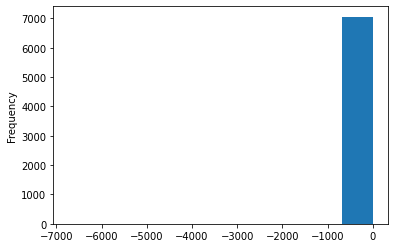

In [26]:
us_finance_firms['OPM'] = winsorize(us_finance_firms['OPM'], limits=[0.0001, 0.02])
us_finance_firms['OPM'].plot.hist();

EN ESTE HISTOGRAMA PODEMOS VER COMO VARIAN LOS VALORES DE OPM, PODEMOS VER COMO LA MAYORIA DE LOS VALORES SE ENCUENTRAN EN 0 Y MUY POCOS VALORES ALCANZAN LOS -7000, DEMOSTRANDONOS QUE HAY BASTANTE SESGO

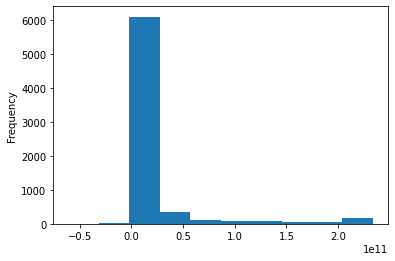

In [27]:
us_finance_firms['Book-to-market ratio'] = winsorize(us_finance_firms['Book-to-market ratio'], limits=[0.0001, 0.02])
us_finance_firms['Book-to-market ratio'].plot.hist();

EN ESTE HISTOGRAMA PODEMOS VER COMO VARIAN LOS VALORES DE BOOK TO MARKET RATIO, PODEMOS VER COMO LA MAYORIA DE LOS VALORES SE ENCUENTRAN EN 0 Y LOS DEMÁS SE TIENEN UN SESGO DE -0.5 A 1E11.

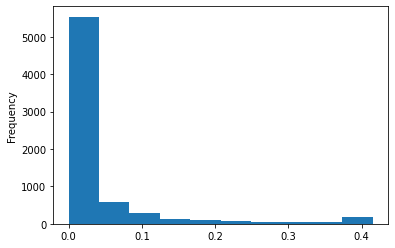

In [28]:
us_finance_firms['Short financial leverage'] = winsorize(us_finance_firms['Short financial leverage'], limits=[0.0001, 0.02])
us_finance_firms['Short financial leverage'].plot.hist();

EN ESTE HISTOGRAMA PODEMOS VER COMO VARIAN LOS VALORES DE SHORT FINANCIAL LEVERAGE, PODEMOS VER COMO LA MAYORIA DE LOS VALORES SE ENCUENTRAN EN 0 Y LOS DEMÁS SE SESGAN UN POCO HASTA 0.4.

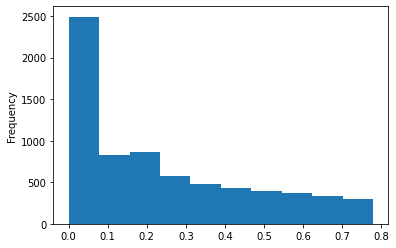

In [29]:
us_finance_firms['Long financial leverage'] = winsorize(us_finance_firms['Long financial leverage'], limits=[0.0001, 0.02])
us_finance_firms['Long financial leverage'].plot.hist();

EN ESTE HISTOGRAMA PODEMOS VER COMO VARIAN LOS VALORES DE LONG FINANCIAL LEVERAGE, PODEMOS VER COMO LA MAYORIA DE LOS VALORES SE ENCUENTRAN EN 0 Y LOS DEMÁS SE SESGAN UN POCO HASTA 0.8.

In [30]:
us_finance_firms[['OPM', 'Book-to-market ratio', 'Short financial leverage', 'Long financial leverage']].describe()

,OPM,Book-to-market ratio,Short financial leverage,Long financial leverage
count,7064.000000,7.064000e+03,7064.000000,7064.000000
mean,-2.531209,1.778521e+10,0.039170,0.235361
std,88.896046,4.609390e+10,0.084534,0.231384
min,-6730.400000,-6.062916e+10,0.000000,0.000000
25%,0.057040,2.225406e+08,0.000000,0.010892
50%,0.169144,1.291555e+09,0.004218,0.174774
75%,0.330675,9.715756e+09,0.031822,0.398203
max,0.903453,2.335570e+11,0.415277,0.779059


- Design and run a multiple regression model to examine whether your selected factors and earnings per share deflated by price can explain/predict annual stock returns. You have to control for industry and firm size. To control for these variables you have to include them as extra independent variables in the model
    - Your independent variables must be in the right scale so that you can compare the values of the variables among different firms of any size
    - For each independent variable you have to check for outliers and do the corresponding adjustments to avoid unreliable results in your regression model
    - You must check for possible multicollinearity problems. Briefly explain what is multicollinearity, run and interpret the corresponding test

In [31]:
def dense_inclusive_pct(x):
    # I subtract one to handle the inclusive bit
    r = x.rank(method='dense') - 1
    return r / r.max() * 100

us_finance_firms['percentile'] = us_finance_firms.groupby('q')['Market value'].apply(dense_inclusive_pct).astype(int)

us_finance_firms["Small"] = us_finance_firms['percentile'] <= 33
us_finance_firms["Small"] = us_finance_firms["Small"].astype(int)

us_finance_firms["Medium"] = (us_finance_firms['percentile'] <= 66) & (us_finance_firms['percentile'] > 33) 
us_finance_firms["Medium"] = us_finance_firms["Medium"].astype(int)

us_finance_firms.drop('percentile', axis=1)
us_finance_firms

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,EPS,Book-to-market ratio,Short financial leverage,Long financial leverage,OPM,EPSP,R,F1R,Small,Medium
2311,AC,2016q4,16295.0,0.0,16163.0,0.0,-5392.0,-10010.0,1103.0,952603.0,...,0.356691,6.742408e+08,0.000000,0.000000,0.008101,0.010858,0.077599,0.261086,0,1
2312,AC,2017q1,4987.0,0.0,9319.0,0.0,-4956.0,12214.0,-8424.0,917633.0,...,-0.334925,5.915507e+08,0.000000,0.000000,-0.868659,-0.009265,0.261086,0.176091,0,1
2313,AC,2017q2,5095.0,0.0,11548.0,0.0,-30.0,-10769.0,-310.0,926837.0,...,0.193847,6.225183e+08,0.000000,0.000000,-1.266536,0.005701,0.176091,0.012676,0,1
2314,AC,2017q3,5248.0,0.0,11360.0,0.0,186.0,-7512.0,67.0,979519.0,...,0.055858,6.004202e+08,0.000000,0.000000,-1.164634,0.001565,0.012676,0.046230,0,1
2315,AC,2017q4,11585.0,0.0,15074.0,0.0,731.0,-24805.0,6247.0,1006915.0,...,0.635779,6.381691e+08,0.000000,0.000000,-0.301165,0.018645,0.046230,0.041260,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318500,XELB,2021q1,7809.0,1835.0,8300.0,160.0,81.0,280.0,-138.0,121815.0,...,-0.136442,8.110468e+08,0.036342,0.183303,-0.318351,-0.068564,1.182431,1.071339,1,0
318501,XELB,2021q2,10764.0,3063.0,8987.0,431.0,-665.0,522.0,-1346.0,134176.0,...,-0.046206,5.322370e+08,0.042631,0.213883,-0.159513,-0.015453,1.210684,0.665219,1,0
318502,XELB,2021q3,11261.0,2865.0,9539.0,163.0,200.0,565.0,-535.0,131203.0,...,-0.068372,1.076248e+09,0.048116,0.209812,-0.115975,-0.045887,0.665219,-0.104443,1,0
318503,XELB,2021q4,8098.0,2904.0,10903.0,1338.0,-430.0,553.0,-1087.0,125781.0,...,-0.332996,1.344749e+09,0.029472,0.260636,-0.870215,-0.305501,-0.104443,-0.289359,1,0


,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,Book-to-market ratio,Short financial leverage,Long financial leverage,OPM,EPSP,R,F1R,percentile,Small,Medium
2311,AC,2016q4,16295.0,0.0,16163.0,0.0,-5392.0,-10010.0,1103.0,952603.0,...,6.742408e+08,0.000000,0.000000,0.008101,0.010858,0.077599,0.261086,40,0,1
2312,AC,2017q1,4987.0,0.0,9319.0,0.0,-4956.0,12214.0,-8424.0,917633.0,...,5.915507e+08,0.000000,0.000000,-0.868659,-0.009265,0.261086,0.176091,40,0,1
2313,AC,2017q2,5095.0,0.0,11548.0,0.0,-30.0,-10769.0,-310.0,926837.0,...,6.225183e+08,0.000000,0.000000,-1.266536,0.005701,0.176091,0.012676,36,0,1
2314,AC,2017q3,5248.0,0.0,11360.0,0.0,186.0,-7512.0,67.0,979519.0,...,6.004202e+08,0.000000,0.000000,-1.164634,0.001565,0.012676,0.046230,35,0,1
2315,AC,2017q4,11585.0,0.0,15074.0,0.0,731.0,-24805.0,6247.0,1006915.0,...,6.381691e+08,0.000000,0.000000,-0.301165,0.018645,0.046230,0.041260,32,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318500,XELB,2021q1,7809.0,1835.0,8300.0,160.0,81.0,280.0,-138.0,121815.0,...,8.110468e+08,0.036342,0.183303,-0.318351,-0.068564,1.182431,1.071339,1,1,0
318501,XELB,2021q2,10764.0,3063.0,8987.0,431.0,-665.0,522.0,-1346.0,134176.0,...,5.322370e+08,0.042631,0.213883,-0.159513,-0.015453,1.210684,0.665219,2,1,0
318502,XELB,2021q3,11261.0,2865.0,9539.0,163.0,200.0,565.0,-535.0,131203.0,...,1.076248e+09,0.048116,0.209812,-0.115975,-0.045887,0.665219,-0.104443,0,1,0
318503,XELB,2021q4,8098.0,2904.0,10903.0,1338.0,-430.0,553.0,-1087.0,125781.0,...,1.344749e+09,0.029472,0.260636,-0.870215,-0.305501,-0.104443,-0.289359,0,1,0


__NOTA:__ EL MÉTODO DE WINSORIZACIÓN PARA ENCARGARNOS DE LOS OUTLIERS, SE REALIZARON PREVIAMENTE.

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()

vif  = us_finance_firms[["F1R", "EPSP", "OPM", 'Short financial leverage', 'Long financial leverage']]

vif_data["feature"] = vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(vif.values, i) for i in range(len(vif.columns))]

print(vif_data)

                    feature       VIF
0                       F1R  1.050955
1                      EPSP  1.037987
2                       OPM  1.000443
3  Short financial leverage  1.052145
4   Long financial leverage  1.064342


CON LOS DATOS OBTENIDOS  TRAS CALCULAR EL VIF (VARIANCE INFLATION FACTO) EN LA PARTE DE ARRIBA CONSIDERANDO QUE PARA CADA VARIABLE COMO NÚMERO LIMITE EL 10, PODEMOS SABER QUE NO HAY MULTICOLINEARIDAD PARA NINGUNA DE LA MEDIDAS SELECCIONADAS PARA EL MODELO, POR LO QUE NO SERÁ NECESARIO ELIMINAR NINGUNA VARIABLE.

- Interpret your model
    - Interpret the results of each coefficient (beta and their statistical significance)
    - Interpret the R-squared of the model

In [33]:
# Getting x and y parameters for the model prediction
x = us_finance_firms[['EPS', 'OPM', 'EPSP', 'Book-to-market ratio', 'Short financial leverage', 'Long financial leverage', 'Small', 'Medium']]
y = us_finance_firms['F1R']

# Getting information to interpret a model
x = sm.add_constant(x)
results = sm.OLS(y, x, missing="drop").fit()
pred = results.predict(x)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    F1R   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     52.23
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           9.27e-83
Time:                        10:42:53   Log-Likelihood:                -4005.2
No. Observations:                7064   AIC:                             8028.
Df Residuals:                    7055   BIC:                             8090.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

INTERPRETACIÓN DEL MODELO OBTENIDO:

NUESTRA VARIABLE DEPENDIENTE EN ESTE CASO FUERON LOS RETORNOS CONTINUOS COMPUESTOS TOMANDO COMO VARIABLES INDEPENDIENTES LOS EPS (EARNINGS PER SHARE), OPM (OPERATING PROFIT MARGIN), BOOK TO MARKET RATIO, SHORT FINANCIAL LEVERAGE, LONG FINANCIAL LEVERAGE Y SIZE QUE ES EL TAMAÑO DE INDUSTRIA EN BASE AL MARKET VALUE SEPARADO EN TRES CATEGORIAS (SMALL, MEDIUM Y BIG).

CON BASE A LO PRESENTE EN NUESTRO MODELO DE PREDICCIÓN PODEMOS DECIR:

NUESTRA VARIABLE MÁS EXPLICATIVA EN EL MODELO FUE EL EPSP (EARNINGS PER SHARE DEFLATED BY PRICE), ESTO PODEMOS SABERLO PORQUE SU T-VALUE ES LA QUE POSEE EL VALOR MÁS GRANDE, YA QUE ES LA QUE NOS DICE LA DISTANCIA DE LA BETA REAL A SU VALOR NULO EN DESVIACIONES ESTÁNDAR.

AL CORRER EL MODELO SE PUDO DETERMINAR QUE TODAS LAS VARIABLES ERAN SIGNIFICATES, YA QUE EL PVALUE FUE CERCANO A 0 EN CASI TODAS A EXCEPCIÓN DEL SHORT FINANCIAL LEVERAGE QUE FUE LA MENOS SIGNIFICATIVA YA QUE OBTUVO UN PVALUE DE 0.27, LO QUE PODRIA TOMARSE A CONSIDERACIÓN PARA QUITAR DICHO DATO.

TAMBIÉN PODEMOS DECIR QUE LOS CAMBIOS EN LA VARIABLE DEPENDIENTE TIENE UNA MAYOR SENSIBILIDAD CON RESPECTO A LOS EPSP, ESTO PODEMOS SABERLO PORQUE ES LA QUE TIENE UN VALOR MÁS GRANDO EN SU COEFICIENTE.

POR EL VALOR OBTENIDO EN LA R^2 QUE ES DE 0.05, CON LO QUE PODEMOS SABER QUE LA PRECISIÓN DEL MODELO GENERADO ES DE APROXIMADAMENTE 5%, CON LO QUE PODEMOS DECIR QUE ES MUY BAJO.

LOS COEFICIENTE PARA LAS DIFERENTES TAMAÑOS DE EMPRESA SON:
- SMALL: 0.0409 + 0.0302(EPS) + 0.0001(OPM) + 0.4334(EPSP) -7.082e-13(Book-to-market ratio) - 0.0660(Short financial leverage ) - 0.0637(Long financial leverage)
- MEDIUM: 0.0992 + 0.0302(EPS) + 0.0001(OPM) + 0.4334(EPSP) -7.082e-13(Book-to-market ratio) - 0.0660(Short financial leverage ) - 0.0637(Long financial leverage)
- BIG: 0.1497 + 0.0302(EPS) + 0.0001(OPM) + 0.4334(EPSP) -7.082e-13(Book-to-market ratio) - 0.0660(Short financial leverage ) - 0.0637(Long financial leverage)

<br>

- Adjustments to your model. If there is one or more independent variables (factors or control variables) that were not significant, drop them from your model. You have to run and interpret your final model.

In [34]:
# Getting x and y parameters for the model prediction
x = us_finance_firms[['EPS', 'OPM', 'EPSP', 'Book-to-market ratio', 'Long financial leverage', 'Small', 'Medium']]
y = us_finance_firms['F1R']

# Getting information to interpret a model
x = sm.add_constant(x)
results = sm.OLS(y, x, missing="drop").fit()
pred = results.predict(x)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    F1R   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     59.52
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           2.07e-83
Time:                        10:42:53   Log-Likelihood:                -4005.8
No. Observations:                7064   AIC:                             8028.
Df Residuals:                    7056   BIC:                             8082.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

ELIMINANDO LA VARIABLE INDEPENDIENTE MENOS SIGNIFICATIVA, PODEMOS VER QUE NUESTRO MODELO NO TUVO CAMBIOS SIGNIFICATIVOS, YA QUE EL VALOR DE NUESTRA R^2 SE MANTUVO IGUAL QUE CON ESTA EN EL MODELO.